In [41]:
import numpy as np
import scipy.io as sio
from glob import glob
from tqdm import tqdm
from scipy.signal import convolve2d
from scipy.interpolate import RectBivariateSpline
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
from astropy.modeling import models, fitting
import astropy.units as u
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import minimize
import sys
sys.path.append('../python/')
import chroma
%matplotlib inline
psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/'

In [91]:
psf_model=pickle.load(open('psf_model.p','rb'))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:98: RuntimeWarning: Mean of empty slice


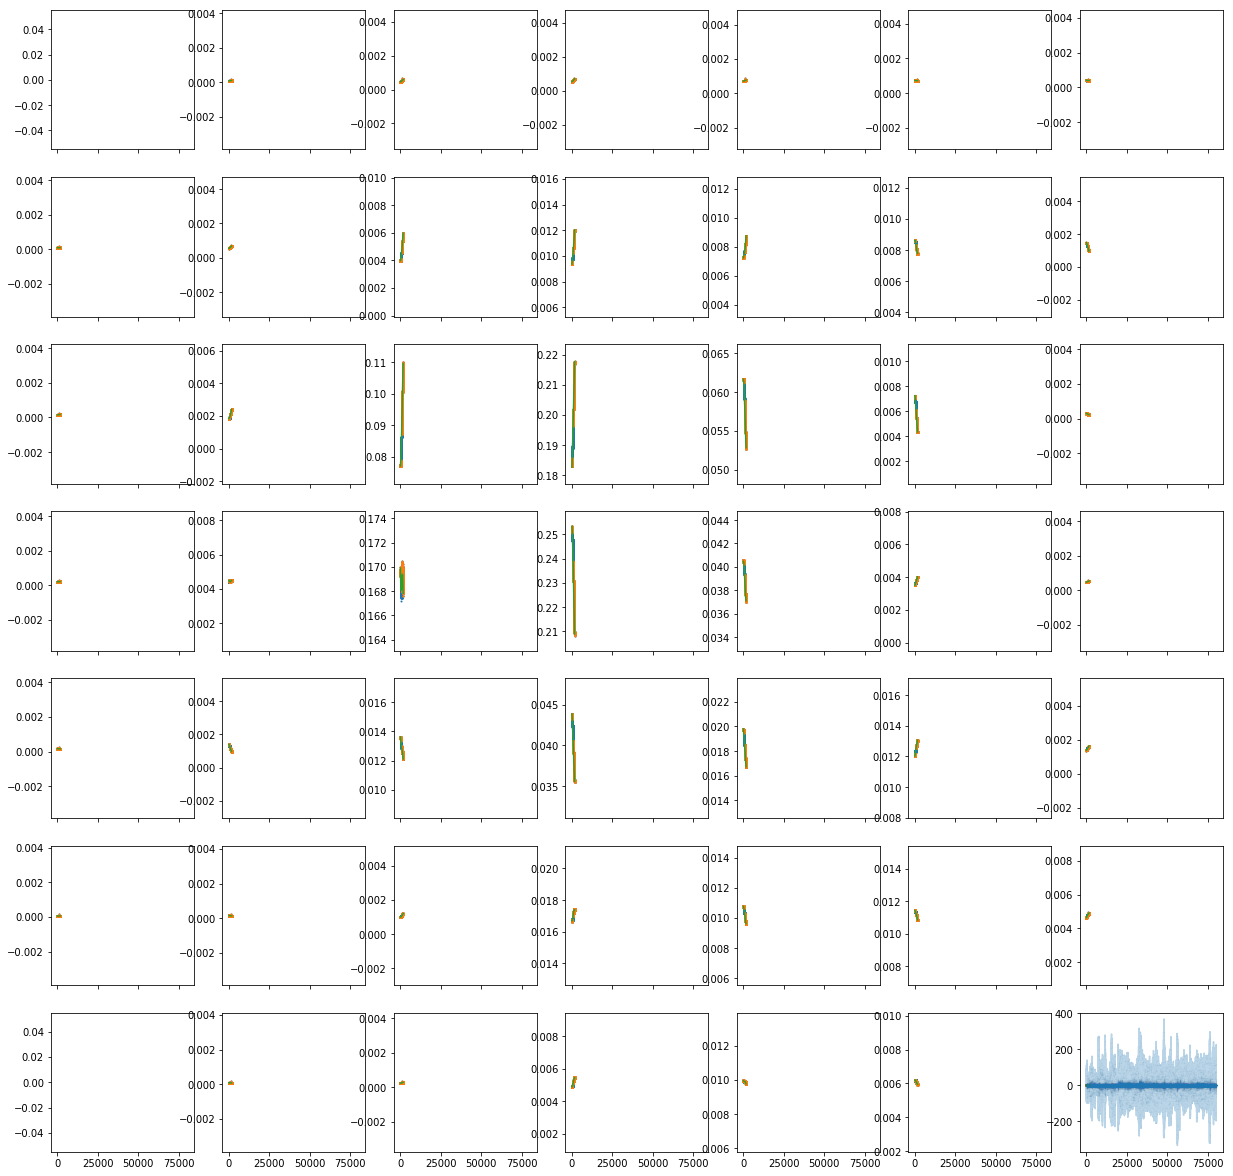

In [96]:
X,Y=np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,2,2+1*0.1))
lam=np.asarray([(f.split('_')[-1])[0:-4] for f in fnames],dtype='float')

fnames=glob('../data/tabby/*.fits')

temperature=6750*u.K

plot=False
    
for f in fnames[1:]:
    h=fits.open(f)
    data=h[1].data['FLUX']
    time=h[1].data['TIME']
    times=chroma.fluxplot(f,plot=False)

    output=h[0].header['OUTPUT']
    module=h[0].header['MODULE']



    fit=fitting.LevMarLSQFitter()
    

    psf_xshifts=np.zeros(len(lam))
    psf_yshifts=np.zeros(len(lam))
    
    for l in (xrange(len(lam))):
        g_init=models.Gaussian2D(x_mean=0.5,y_mean=0.5,amplitude=np.nanmax(psf_model[module-1,output-1,l,:,:]))
        g=fit(g_init,X,Y,psf_model[module-1,output-1,l,:,:])
        psf_xshifts[l],psf_yshifts[l]=g.x_mean.value,g.y_mean.value
        

    flux_lam = blackbody_lambda(np.asarray(lam,dtype=float)*u.nanometer, temperature)
    psf2d=np.zeros((np.shape(psf_model)[3],np.shape(psf_model)[4]))
    for l,w in enumerate(flux_lam):
        model=RectBivariateSpline(X[0]+psf_xshifts[l],Y[:,0]+psf_yshifts[l],psf_model[module-1,output-1,l,:,:])
        psf2d+=w.value*model(X[0],Y[:,0])
    psf2d/=chroma.trapezoidal_area(np.transpose([X.ravel(),Y.ravel(),psf2d.ravel()]))

    dt=300
    nt=50

    resids=np.zeros((nt,np.shape(psf2d)[0],np.shape(psf2d)[1]))
    ts=['{}K'.format(int(i)) for i in np.round(np.linspace(temperature.value-dt,temperature.value+dt,nt),-2)]
    for i,temp in enumerate(np.linspace(temperature.value-dt,temperature.value+dt,nt)*u.K):
        flux_lam = blackbody_lambda(np.asarray(lam,dtype=float)*u.nanometer, temp)
        h=np.zeros((np.shape(psf_model)[3],np.shape(psf_model)[4]))
        for l,w in enumerate(flux_lam):
            model=RectBivariateSpline(X[0]+psf_xshifts[l],Y[:,0]+psf_yshifts[l],psf_model[module-1,output-1,l,:,:])
            h+=w.value*model(X[0],Y[:,0])
        h/=chroma.trapezoidal_area(np.transpose([X.ravel(),Y.ravel(),h.ravel()]))
        resids[i,:,:]=h-psf2d
        
    s=np.shape(data)
    if plot==True:
        n=5
        labels=['Redder']
        [labels.append(l) for l in ['']*int(n-2)]
        labels.append('Bluer')

        fig,ax=plt.subplots(1,n,figsize=(n*3,3))
        for j,i in enumerate(np.linspace(0,nt-1,n)):
            f=resids[int(i)]
            model=RectBivariateSpline(X[0]+2.5,Y[:,0]+4,f/psf2d)
            im=ax[j].imshow(100.*model(np.arange(s[1]),np.arange(s[2])),vmin=-2,vmax=2)
            ax[j].set_title(labels[j])
        plt.suptitle('Polychromatic Model Residuals')
        cbar_ax = fig.add_axes([0.12, 0.0, 0.8, 0.03])
        cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
        cbar.set_label('% Change')
    
    shape_model=np.zeros((s[0],s[1],s[2]))

    totflux=np.nansum(np.nansum(data,axis=1),axis=1)
    #if plot==True:
    fig,ax=plt.subplots(s[1],s[2],figsize=(s[2]*3,s[1]*3),sharex=True)
    for i in xrange(s[1]):
        for j in xrange(s[2]):
            x,y=np.arange(len(data)),data[:,i,j]/totflux
            good=chroma.qualify(time,data,times)
            if len(good)==0:
                continue

            flat=np.polyval(np.polyfit(x[good],y[good],4),x)
            shape_model[:,i,j]=flat
    #        if plot==True:
            ax[i,j].scatter(x,y,s=1)
            ax[i,j].scatter(x[good],y[good],s=1)
            ax[i,j].plot(x,flat,c='C2')

            

    flux=[]
    for dat,mod in zip(data,shape_model):
        def psf(scale):
            return 1./float(len(dat.ravel()))*np.nansum((dat-scale*mod)**2/dat)
        initial_guess=np.nanmean(dat)/np.nanmean(mod)
        f=minimize(psf,initial_guess)
        flux.append(f.x[0])
    fluxmodels=np.asarray([f*m for f,m in zip(flux,shape_model)])
    plt.figure()
    plt.plot(data.ravel()-fluxmodels.ravel(),marker='.',ms=0.1,alpha=0.3)
    break
    

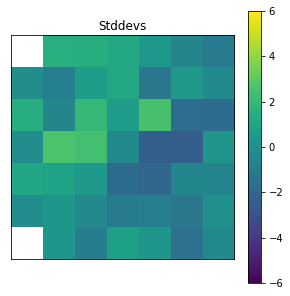

In [117]:
reload(chroma)
stds=(np.nanstd((data-fluxmodels)/fluxmodels,axis=0))
vals=(data-fluxmodels)/fluxmodels
chroma.animateim(vals/stds,vmin=-6,vmax=6,colorbar=True,title='Stddevs',outfile='tabbytest2.mp4')

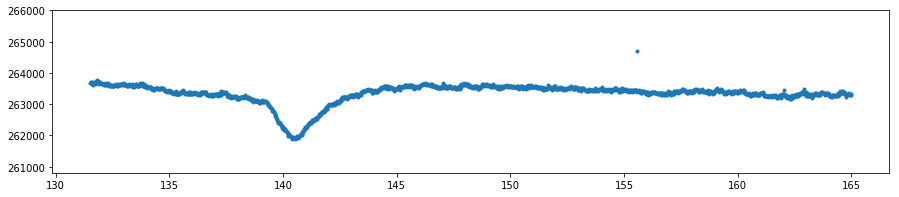

In [70]:
for f in fnames[1:]:
    h=fits.open(f)
    data=h[1].data['FLUX']
    time=h[1].data['TIME']
    y=np.nansum(np.nansum(data,axis=1),axis=1)
    ok=np.where((y!=0))[0]
    std=np.nanstd(y[ok])
    plt.figure(figsize=(15,3))
    plt.scatter(time[ok],y[ok],marker='.')
    plt.ylim(np.nanmedian(y[ok])-std*8,np.nanmedian(y[ok])+std*8)
    break

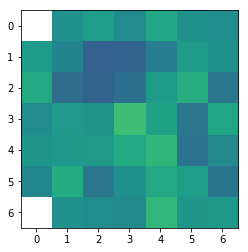

In [116]:
stds=(np.nanstd((data-fluxmodels)/fluxmodels,axis=0))
vals=(data-fluxmodels)/fluxmodels
plt.imshow(vals[430]/stds,vmin=-6,vmax=6)